# Dependencies

In [28]:
import sys
from datetime import datetime, timedelta
import copy
from operator import itemgetter
import os
from pathlib import Path

from scipy.stats import pearsonr
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

from Chapter7.PrepareDatasetForLearning import PrepareDatasetForLearning
from Chapter7.Evaluation import ClassificationEvaluation
from Chapter7.Evaluation import RegressionEvaluation
from Chapter7.LearningAlgorithms import ClassificationAlgorithms
from Chapter7.LearningAlgorithms import RegressionAlgorithms
from Chapter3.OutlierDetection import DistributionBasedOutlierDetection
from util.VisualizeDataset import VisualizeDataset


# Dataset generation from files

In [29]:
import numpy as np
import pandas as pd

def get_ds_infos():
    """
    Read the file includes data subject information.
    
    Data Columns:
    0: code [1-24]
    1: weight [kg]
    2: height [cm]
    3: age [years]
    4: gender [0:Female, 1:Male]
    
    Returns:
        A pandas DataFrame that contains inforamtion about data subjects' attributes 
    """ 

    dss = pd.read_csv("data_subjects_info.csv")
    print("[INFO] -- Data subjects' information is imported.")
    
    return dss

def set_data_types(data_types=["userAcceleration", "gravity", "rotationRate"]):
    """
    Select the sensors and the mode to shape the final dataset.
    
    Args:
        data_types: A list of sensor data type from this list: [attitude, gravity, rotationRate, userAcceleration] 

    Returns:
        It returns a list of columns to use for creating time-series from files.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])
    print(dt_list)
    return dt_list


def creat_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    """
    Args:
        dt_list: A list of columns that shows the type of data we want.
        act_labels: list of activites
        trial_codes: list of trials
        mode: It can be "raw" which means you want raw data
        for every dimention of each data type,
        [attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)].
        or it can be "mag" which means you only want the magnitude for each data type: (x^2+y^2+z^2)^(1/2)
        labeled: True, if we want a labeld dataset. False, if we only want sensor values.

    Returns:
        It returns a time-series of sensor data.
    
    """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+7)) # "7" --> [act, code, weight, height, age, gender, trial] 
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = 'A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id,
                            sub_id-1,
                            ds_list["weight"][sub_id-1],
                            ds_list["height"][sub_id-1],
                            ds_list["age"][sub_id-1],
                            ds_list["gender"][sub_id-1],
                            trial          
                           ]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset
#________________________________


ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["attitude", "userAcceleration", "gravity", "rotationRate"]
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ACT_LABELS#[0:4]#
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
dataset = creat_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    
dataset.head()

[INFO] -- Selected sensor data types: ['attitude', 'userAcceleration', 'gravity', 'rotationRate']
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog', 'std', 'sit']
[['attitude.roll', 'attitude.pitch', 'attitude.yaw'], ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z'], ['gravity.x', 'gravity.y', 'gravity.z'], ['rotationRate.x', 'rotationRate.y', 'rotationRate.z']]
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(1412865, 19)


,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,act,id,weight,height,age,gender,trial
0,1.528132,-0.733896,0.696372,0.294894,-0.184493,0.377542,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.0,0.0,102.0,188.0,46.0,1.0,1.0
1,1.527992,-0.716987,0.677762,0.219405,0.035846,0.114866,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.0,0.0,102.0,188.0,46.0,1.0,1.0
2,1.527765,-0.706999,0.670951,0.010714,0.134701,-0.167808,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.0,0.0,102.0,188.0,46.0,1.0,1.0
3,1.516768,-0.704678,0.675735,-0.008389,0.136788,0.094958,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,0.0,0.0,102.0,188.0,46.0,1.0,1.0
4,1.493941,-0.703918,0.672994,0.199441,0.353996,-0.044299,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.0,0.0,102.0,188.0,46.0,1.0,1.0


In [4]:
dataset.act.unique()

array([0., 1., 2., 3., 4., 5.])

In [5]:
print(dataset.trial.unique(), len(dataset.trial.unique()))

[ 1.  2. 11.  3.  4. 12.  7.  8. 15.  9. 16.  6. 14.  5. 13.] 15


# Preprocessing

#### Check for missing values

In [54]:
#Check all columns for missing values

for i in dataset.columns:
    print("Num missing in", i, ":", dataset[i].isnull().sum())

Num missing in attitude.roll : 0
Num missing in attitude.pitch : 0
Num missing in attitude.yaw : 0
Num missing in userAcceleration.x : 0
Num missing in userAcceleration.y : 0
Num missing in userAcceleration.z : 0
Num missing in gravity.x : 0
Num missing in gravity.y : 0
Num missing in gravity.z : 0
Num missing in rotationRate.x : 0
Num missing in rotationRate.y : 0
Num missing in rotationRate.z : 0
Num missing in act : 0
Num missing in weight : 0
Num missing in height : 0
Num missing in age : 0
Num missing in gender : 0
Num missing in trial : 0


#### Check for outliers 

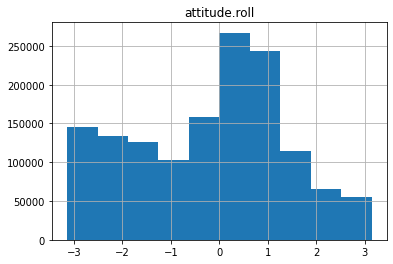

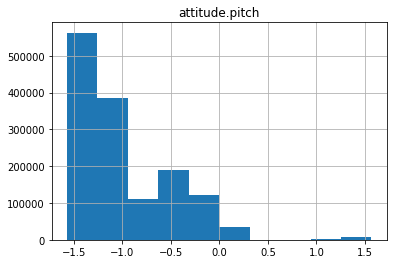

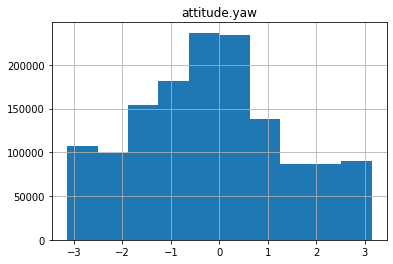

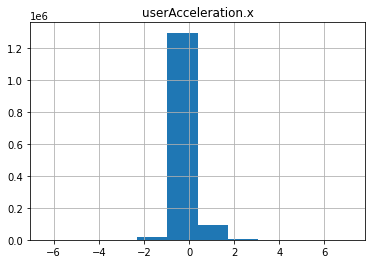

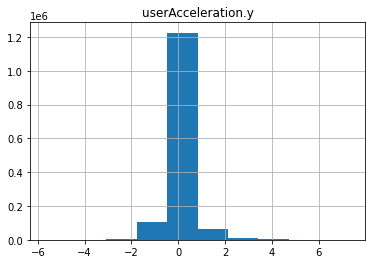

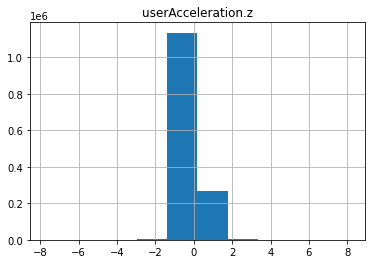

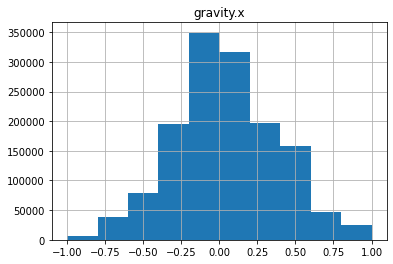

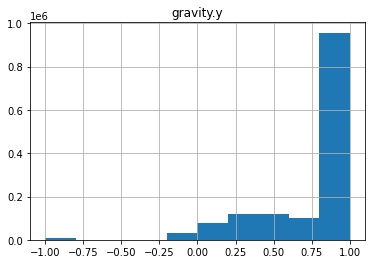

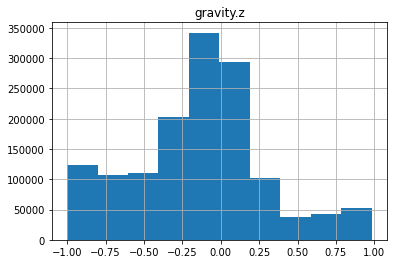

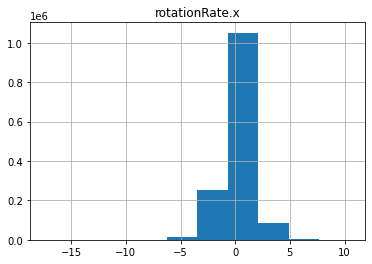

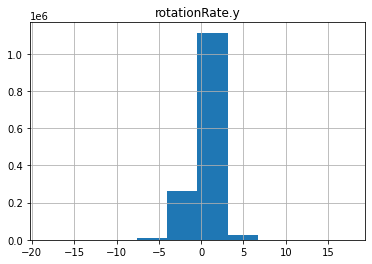

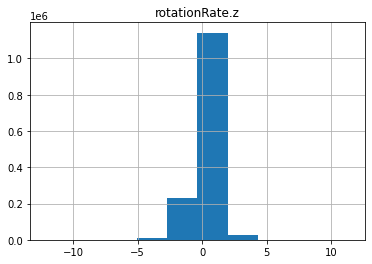

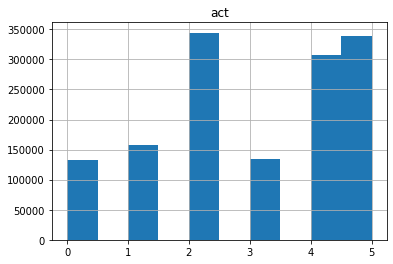

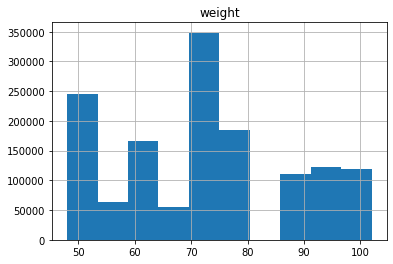

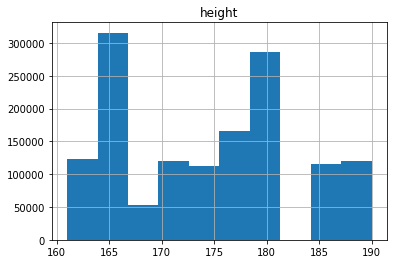

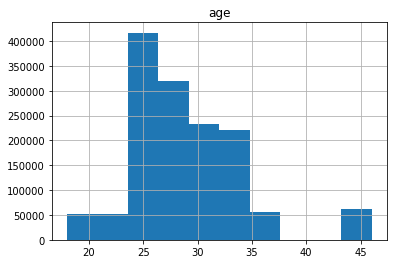

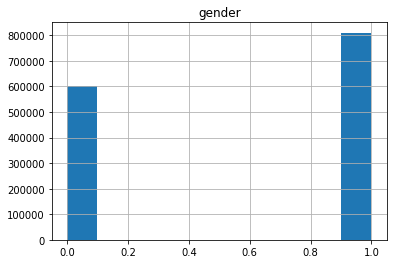

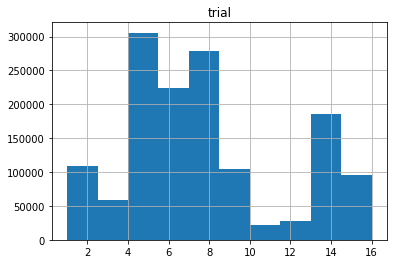

In [60]:
#Visual inspection seems to show everything within a normal range
for i in dataset.columns:
    plt.figure()
    plt.title(i)
    dataset[i].hist()
    plt.show()

In [6]:
#dataset.to_csv(Path('data_date_time_index.csv'))


# Outlier detection

In [23]:
dataset = pd.read_csv(Path('data_date_time_index.csv'))
# # dataset.drop(columns=['Unnamed: 0.1'], inplace=True)
# dataset.set_index('Unnamed: 0',inplace=True)
# dataset.index = dataset.index.astype(int)

In [37]:
dataset.columns[:12]

Index(['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'userAcceleration.x',
       'userAcceleration.y', 'userAcceleration.z', 'gravity.x', 'gravity.y',
       'gravity.z', 'rotationRate.x', 'rotationRate.y', 'rotationRate.z'],
      dtype='object')

In [31]:
vis = VisualizeDataset()
dist_detection = DistributionBasedOutlierDetection()
trials = [dataset[dataset['trial']==i] for i in dataset['trial'].unique()]

In [41]:
# id_ = dataset['id']
# dataset.drop(columns=['id'], inplace=True)
for i in range(len(trials)):
    for col in list(trials[i]):
        print(col)
        #print(trials[i].columns)

        dist_detection.chauvenet(trials[i], col)

        #vis.plot_binary_outliers(dataset, col, col+'_outlier')

attitude.roll
0          1.096643
1          1.096546
2          1.096390
3          1.088817
4          1.073098
             ...   
1363502    1.352904
1363503    1.419425
1363504    1.473053
1363505    1.517894
1363506    1.608910
Name: attitude.roll, Length: 50246, dtype: float64
attitude.roll


KeyError: 1751

In [42]:
for col in dataset:

        dist_detection.chauvenet(dataset, col)

0          1.087781
1          1.087692
2          1.087547
3          1.080528
4          1.065957
             ...   
1412860    1.399313
1412861    1.399615
1412862    1.399856
1412863    1.400010
1412864    1.400031
Name: attitude.roll, Length: 1412865, dtype: float64
attitude.roll
0          0.511556
1          0.545779
2          0.565994
3          0.570692
4          0.572230
             ...   
1412860    1.225644
1412861    1.225652
1412862    1.225466
1412863    1.225199
1412864    1.225195
Name: attitude.pitch, Length: 1412865, dtype: float64
attitude.pitch
0          0.547422
1          0.535375
2          0.530966
3          0.534063
4          0.532288
             ...   
1412860    0.038745
1412861    0.038705
1412862    0.038714
1412863    0.038712
1412864    0.038662
Name: attitude.yaw, Length: 1412865, dtype: float64
attitude.yaw
0          0.910410
1          0.680407
2          0.044559
3          0.013645
4          0.619580
             ...   
1412860    0.014319

In [43]:
dataset.to_csv(Path('outliers_detected_set.csv'))

In [44]:
dataset.head()

,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,gravity.x,gravity.y,gravity.z,rotationRate.x,...,act_outlier,id_outlier,weight_outlier,height_outlier,age_outlier,gender_outlier,trial_outlier,attitude.roll_outlier_outlier,attitude.pitch_outlier_outlier,attitude.yaw_outlier_outlier
0,1.528132,-0.733896,0.696372,0.294894,-0.184493,0.377542,0.741895,0.669768,-0.031672,0.316738,...,False,False,False,False,False,False,False,False,False,False
1,1.527992,-0.716987,0.677762,0.219405,0.035846,0.114866,0.753099,0.657116,-0.032255,0.842032,...,False,False,False,False,False,False,False,False,False,False
2,1.527765,-0.706999,0.670951,0.010714,0.134701,-0.167808,0.759611,0.649555,-0.032707,-0.138143,...,False,False,False,False,False,False,False,False,False,False
3,1.516768,-0.704678,0.675735,-0.008389,0.136788,0.094958,0.760709,0.647788,-0.041140,-0.025005,...,False,False,False,False,False,False,False,False,False,False
4,1.493941,-0.703918,0.672994,0.199441,0.353996,-0.044299,0.760062,0.647210,-0.058530,0.114253,...,False,False,False,False,False,False,False,False,False,False


# Estimating frequency

In [6]:
short_trials = [dataset[dataset['trial']==i] for i in range(11,len(dataset.trial.unique())+1)]

In [7]:
hz_list = []
for j in dataset.index.unique():
    hz_list.append(np.mean(np.array([len(short_trials[i][short_trials[i].index==j])for i in range(len(short_trials))])/45))

In [8]:
np.mean(hz_list)

55.83611111111111

In [9]:
long_trials = [dataset[dataset['trial']==i] for i in range(11)]
hz_list = []
for j in dataset.index.unique():
    hz_list.append(np.mean(np.array([len(long_trials[i][long_trials[i].index==j])for i in range(len(long_trials))])/150))

In [10]:
np.mean(hz_list)

27.309242424242427

# Feature engineering

#### Frequency domain 

In [11]:
milliseconds_per_instance = (1/50)*1000
print(milliseconds_per_instance)

20.0


### Split for computation

In [ ]:
dataset1 = dataset[:int(len(dataset)*0.33)]
dataset1 = dataset[int(len(dataset)*0.33):int(len(dataset)*0.66):]
dataset1 = dataset[int(len(dataset)*0.66):]

In [ ]:
from Chapter4.FrequencyAbstraction import FourierTransformation


FreqAbs = FourierTransformation()
fs = float(1000)/milliseconds_per_instance

periodic_predictor_cols = list(dataset.columns[:12])

Cormac

In [1]:
dataset1 = FreqAbs.abstract_frequency(dataset1, periodic_predictor_cols, int(float(10000)/milliseconds_per_instance), fs)

NameError: name 'dataset' is not defined

Abel

In [ ]:
dataset2 = FreqAbs.abstract_frequency(dataset2, periodic_predictor_cols, int(float(10000)/milliseconds_per_instance), fs)

Natasja

In [ ]:
dataset3 = FreqAbs.abstract_frequency(dataset3, periodic_predictor_cols, int(float(10000)/milliseconds_per_instance), fs)

### Merge back together

In [ ]:
dataset = pd.concat([dataset1, dataset2, dataset3])

#### Time Domain

# Feature Selection

We perform selection on 20% of the dataset.

#### Initial Train split for feature selection

In [ ]:
train= dataset.sample(frac=0.2,random_state=200)
train_x = train.drop(columns=['act'])
train_y = train['act']

#### Forward Selection

In [ ]:
 selected_features, ordered_features, ordered_scores = FeatureSelectionClassification().forward_selection(max_features, train_X, train_y)

In [ ]:
dataset = dataset[selected_features]

In [ ]:
#dataset.to_csv(Path('selected_set.csv'))

# Experiments - whole data set

In [ ]:
# dataset = pd.read_csv(Path('selected_set.csv'))

Begin with random forest across all targets. Whatever target seems to be most predictable we will apply other algorithms to.

Predict activity label - whole dataset.

In [ ]:
#Take random samples for this experiment
train=dataset.sample(frac=0.3) #random state is a seed value
test=dataset.drop(train.index)
test= test.sample(frac=0.3)

train_y = train['act']
train_X = train.drop(columns=['act'])
test_y = test['act']
test_X = test.drop(columns=['act'])

pred_training_y, pred_test_y, frame_prob_training_y, frame_prob_test_y = ClassificationAlgorithms().random_forest(train_X, train_y, test_X)



Predict age based on sensor values - whole dataset

In [ ]:
train=dataset.sample(frac=0.3)
test=dataset.drop(train.index)
test= test.sample(frac=0.3)

train_y = train['age']
train_X = train.drop(columns=['age'])
test_y = test['age']
test_X = test.drop(columns=['age'])

return pred_training_y, pred_test_y = RegressionAlgorithms().random_forest(self, train_X, train_y, test_X)

Predict gender - whole dataset

In [ ]:
train=dataset.sample(frac=0.3)
test=dataset.drop(train.index)
test= test.sample(frac=0.3)

train_y = train['gender']
train_X = train.drop(columns=['gender'])
test_y = test['gender']
test_X = test.drop(columns=['gender'])

pred_training_y, pred_test_y, frame_prob_training_y, frame_prob_test_y = ClassificationAlgorithms().random_forest(train_X, train_y, test_X)

Predict weight - whole dataset

In [ ]:
train=dataset.sample(frac=0.3)
test=dataset.drop(train.index)
test= test.sample(frac=0.3)

train_y = train['weight']
train_X = train.drop(columns=['weight'])
test_y = test['weight']
test_X = test.drop(columns=['weight'])


return pred_training_y, pred_test_y = RegressionAlgorithms().random_forest(self, train_X, train_y, test_X)

# Experiments - By Trial

In [7]:
trials = [dataset[dataset['trial']==i] for i in dataset['trial'].unique()]

In [8]:
class_alg = ClassificationAlgorithms()

def generate_sets(data_set):
    train=dataset.sample(frac=0.3) #random state is a seed value
    test=dataset.drop(train.index)
    test= test.sample(frac=0.3)

    train_y = train['act']
    train_X = train.drop(columns=['act'])
    test_y = test['act']
    test_X = test.drop(columns=['act'])
    
    return train_y, train_X, test_y, test_X



def train_classification(train_y, train_X, test_y, test_X, class_alg):
    pred_training_y, pred_test_y, frame_prob_training_y, frame_prob_test_y = class_alg.random_forest(train_X, train_y, test_X)
    return pred_training_y, pred_test_y, frame_prob_training_y, frame_prob_test_y

def evaluate_classifcation(y_true, y_pred):
    evaluation = ClassificationEvaluation()
    return evaluation.accuracy(y_true, y_pred), evaluation.precision(y_true, y_pred), evaluation.recall(y_true, y_pred), evaluation.f1(y_true, y_pred)



Random forest for the labels by trial

In [ ]:
acc = []
prec = []
recall = []
f1 = []

for subset in trials:
    train_y, train_X, test_y, test_X = generate_sets(subset)
    pred_training_y, pred_test_y, frame_prob_training_y, frame_prob_test_y = train_classification(train_y, train_X, test_y, test_X, class_alg)
    accuracy, precision, recall, f1_ = evaluate_classifcation(test_y, pred_test_y)
    acc.append(accuracy)
    prec.append(precision)
    recall.append(recall)
    f1.append(f1_)